In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]

#target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')



In [2]:
from numrisk.utils.data import get_data_majduge

df = get_data_majduge()

number of subjects found: 66


In [3]:
from utils import get_decoding_info

pred = []
for sub in subjects:
    pred.append(get_decoding_info(sub,bids_folder=bids_folder))

pred = pd.concat(pred).join(df, how='inner')

/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-65/func/sub-65_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv
/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-66/func/sub-66_ses-1_mask-NPC_R_space-T1w_pars.tsv


In [4]:
import pingouin as pg

r = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d['log(n1)']))

/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


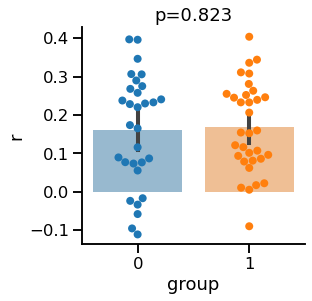

In [10]:
temp = r.groupby(['subject','group']).mean()
sns.set_context('talk')

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, alpha=0.5)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()

In [6]:
target_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

r.reset_index(['group', None])[['r']].to_csv(op.join(target_folder,'decoding_r.csv'))

In [24]:
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

magjudge_probit_params = pd.read_csv(op.join(source_folder,'probit-2_all-subwise-params.csv')).set_index('subject')

gammas_symbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-symbolic_gammas.csv'))
gammas_symbolic = gammas_symbolic.set_index('subject').drop(columns=['Unnamed: 0'])

df_comb = r.reset_index(['group', None])[['r', 'group']].join(magjudge_probit_params, how='inner').join(gammas_symbolic, how='inner',rsuffix='_symbolic')
df_comb.head()

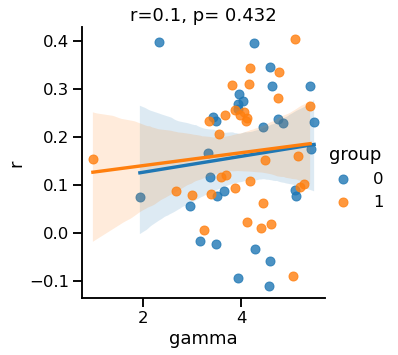

In [45]:
import pingouin

#df_comb = df_comb[df_comb['group'] == 1]
y_var = 'r' 
x_var = 'gamma'

cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group') # 
fig.set(title=f'r={r_}, p= {p}') 